# Plotting ROC - Curves with template banks

Emma Vandrey, 10019590

This notebook is only used to calculate the ROC curves for methods 1 and 2 (but mainly 1) when using template banks of varying accuracy.
First, the necessary packages are imported and constant parameters of the data are defined.

In [8]:
import os
import pandas as pd
import sys
import subprocess
import uuid
import numpy as np
import matplotlib.pyplot as plt

In [9]:
exe_dir = 'C:/Users/emmav/OneDrive/Dokumente/DataAnalysisLab22/datalab_ss22/code' # directory where the executable is found /PATH/TO/PROBER
output_dir = 'C:/Users/emmav/OneDrive/Dokumente/DataAnalysisLab22/datalab_ss22/code' # directory to save the data files
data_dir =  'C:/Users/emmav/OneDrive/Dokumente/DataAnalysisLab22/datalab_ss22/code'  # directory for jupyter to find the data in - same as data_dir if not using 

In [10]:
T_obs = 180.0;
dt_data = 1/4096;
N_data = int(180/dt_data);
sigma_data = 25.0;

Next, the functions calling the C programs "generate_source" and "prober" are defined.

In [11]:
# Call generate source with given parameters, use default values if no input
def generate_source(
    outputFile=None, 
    sigma=25.0, 
    delta_T=dt_data, 
    N=N_data,
    f=0, 
    phi=0, 
    A=0, 
    r=0
):
    """
    Usage: ./generate_source  [-h] [-o <file>] [-s <float>] [-d <float>] [-N <int>] [-f <float>] [-p <float>] [-a <float>] [-r <int>]
      -o, --output=<file>       output file
      -s, --sigma=<float>       standard deviation sigma
      -d, --deltaT=<float>      delta T betwean measurements
      -N, --length=<int>        number of elements
      -f, --freq=<float>        frequency
      -p, --phase=<float>       phase
      -a, --amplitude=<float>   signal amplitude
      -r, --random=<int>        if set to 1, generate random signal
      -h, --help                print this help and exit
    """
    if delta_T == None : 
        delta_T = 1/N
    if outputFile == None:
        outputFile = "data_" + str(uuid.uuid4()) + ".csv"
    
    outputPath = os.path.join(output_dir, outputFile) # output_dir + "/" + "myfilename.csv"
    exe_path = os.path.join(exe_dir, 'generate_source')
    
    cmd_str = f"{exe_path} -o {outputPath} -s {sigma} -d {delta_T} -N {N} -f {f} -p {phi} -a {A} -r {r}"
    
    # Optionally print the command line and test it outside the notebook
    #print(cmd_str)
    
    cmd = cmd_str.split(' ')
    process = subprocess.Popen(cmd,stdout=subprocess.PIPE)

    out, err = process.communicate()
    if err:
        print('The process raised an error:', err.decode())
    #if out:
        #print('The process has an output:', out.decode())

    return os.path.join(data_dir, outputFile)


In [17]:
def prober(inputFile, outputFile=None, f=0, phi=0, templateFile=None, mod=1):
    """
    Usage: ./prober  [-h] [-i <file>] [-o <file>] [-f <float>] [-p <float>] [-t <file>] [-m <int>]
      -i, --input=<file>        input file
      -o, --output=<file>       output file
      -f, --freq=<float>        frequency
      -p, --phase=<float>       phase
      -h, --help                print this help and exit
      -t, --templatebank=<file> template bank file
      -m, --method=<int>        select method to analyze signal 1, 2 or 3
    """
    
    if outputFile == None:
        outputFile = "results_" + str(uuid.uuid4()) + ".csv"
    
    exe_path = os.path.join(exe_dir, 'prober')
    
    """
    prober -i data/data_01.csv -o data/results_01.csv -t template.txt -m 1
    """
    
    cmd_str = f"{exe_path} -i {os.path.join(output_dir, inputFile)} -o {os.path.join(output_dir, outputFile)} -m {mod}"
    
    if templateFile:
        cmd_str += f" -t {os.path.join(output_dir, templateFile)} "
    else:
        cmd_str += f" -f {f} -p {phi}"
    
    # Optionally print the command line and test it outside the notebook
    #print(cmd_str)
    
    cmd = cmd_str.split(' ')
    process = subprocess.Popen(cmd,stdout=subprocess.PIPE)
    out, err = process.communicate()
    if err:
        print('The process raised an error:', err.decode())
    if out:
        print(out.decode()) #'The process has an output:', 
    if os.path.isfile(outputFile):
        print(f"Output generated in file {outputFile}")

    return f"{output_dir}/{outputFile}"
    

In [20]:
# return the best result of prober used with a template bank and the corresponding frequency and phase
# output: [frequency, phase, best s-value]
def get_best_result(prober_result_file, method = 1):
    
    result_data = np.loadtxt(prober_result_file)
    if method == 1:
        best_index = np.argmax(result_data[:,2])
    elif method == 2:
        best_index = np.argmin(result_data[:,2])
    else:
        print("This is not a suitable method, use method 1 or 2.")
        return
    
    
    return result_data[best_index]

In [132]:
# determine maximum value of s1
# s1 is only added to list if its corresponding frequency is within the error range of the given frequency
def get_best_s1_check_frequency(result_file_list, freq, f_error = 0.2):
    
    n_files = len(result_file_list)
    f_min = freq - f_error
    f_max = freq + f_error
    
    best_s1_list = []
    for i in range(n_files):
        result_array = np.loadtxt(result_file_list[i])
        s1_list = result_array[:,2]
        best_s1_index = np.argmax(s1_list)
        f = result_array[:,0][best_s1_index]
        if f_min <= f and f <= f_max:
            best_s1_list.append(s1_list[best_s1_index])
        
        
    
    return best_s1_list

In [87]:
# To generate the ROC curve, the threshold to distinguish between noise/signal is varied.
# For the different thresholds, the true positive rate is plotted vs. the false positive rate.
def plot_roc_curve(noise_list, signal_list, n_a, method, plot_title = None, fig_name = None):
    
    # determine the range of s-values in the given files
    s_min = min([min(noise_list), min(signal_list)])
    s_max = max([max(noise_list), max(signal_list)])
    
    # get a list of threshold values
    a_list = np.linspace(s_min,s_max,n_a)
    
    # determine the true positive and false negative rate for all thresholds 
    # save the results in two lists: false positive list, true positive list
    
    N_noise = len(noise_list)
    N_signal = len(signal_list)
    
    false_positive_list = []
    true_positive_list = []
    
    for i in range(len(a_list)):
        fp_count = 0
        tp_count = 0
        for j in range(N_noise):
            if method == 1 and noise_list[j] > a_list[i]:
                fp_count += 1
            elif method == 2 and noise_list[j] < a_list[i]:
                fp_count +=1
                
        false_positive_list.append(fp_count/N_noise)
            
        for k in range(N_signal):
            if method == 1 and signal_list[k] > a_list[i]:
                tp_count += 1
            elif method == 2 and signal_list[k] < a_list[i]:
                tp_count +=1
               
        # divided by N_noise because the same number of files is used for noise and signal,  
        # and the input list with the s list for signals might be shorter if for some files
        # the template with the best result was too far away from the injected frequency
        true_positive_list.append(tp_count/N_noise) 
        
        
    result_list = []
    for n in range(len(a_list)):
        result_list.append([a_list[n], true_positive_list[n], false_positive_list[n]])
        
    
    plt.plot(false_positive_list, true_positive_list)
    plt.xlabel("False positive rate", fontname="Arial", fontsize=13)
    plt.ylabel("True positive rate", fontname="Arial", fontsize=13)
    plt.xticks(fontname="Arial", fontsize=13)
    plt.yticks(fontname="Arial", fontsize=13)
    
    if plot_title:
        plt.title("ROC curve: " + plot_title)
    #else: 
        #plt.title("ROC curve")
        
    plt.savefig(f"ROC_curve_mod{str(method)}_{fig_name}.png", dpi=800)
    plt.show()
        
    return result_list

Here, prober will be used with a template bank, which can be generated by the following function:

In [15]:
# generate a template bank with frequencies between fmin and fmax and phases between p_min and p_max
def generate_template_bank(f_min, f_max, f_steps, p_min, p_max, phase_steps, filename):
    
    freqs = np.linspace(f_min, f_max, f_steps+1) 
    if p_min != p_max:
        phases = np.linspace(p_min, p_max, phase_steps+1)
    else:
        phases = [p_min]
        
    
    result = []

    for f in freqs:
        for ph in phases:
            result.append([f,ph])
            
    np.savetxt(os.path.join(output_dir, filename), result, delimiter=' ')
    file_path = f"{output_dir}/{filename}"
    
    return file_path
    

To obtain a ROC-curve, Monte-Carlo studies are used for which one needs multiple sources. Therefore, the following function is defined to generate many datasets at once.

In [13]:
# generates as many sources with the given parameters as given by number_of_sources
# the values of sigma, dT and N are the same as in the actual data sets to be analysed
# output: list of file paths of the generated sources
def generate_sources_list(file_name_body, number_of_sources, freq = 0, phase = 0, amplitude = 0):
     
    file_paths = []
    
    for i in range(number_of_sources):
        
        generate_source(
            outputFile=f"{file_name_body}_{i+1}.txt", 
            sigma=sigma_data, 
            delta_T=dt_data, 
            N=N_data,
            f=freq, 
            phi=phase, 
            A=amplitude, 
            r=0
        )
        file_paths.append(f"{output_dir}/{file_name_body}_{i+1}.txt")
    
    return file_paths

## Generating the data and template banks

First, sources with just noise and ones with noise + signal (at arbitrary frequency f = 437.127 Hz and phase p = 2.41, amplitude = 2) are generated (200 datasets each). The other parameters (N, dt, sigma) are chosen to be the same as for the actual datasets to be analysed.

In [100]:
noise_list = generate_sources_list("roc_noise", 200, freq = 437.127, phase = 2.41, amplitude = 0);
signal_list_05 = generate_sources_list("roc_signal_05", 200, freq = 437.127, phase = 2.41, amplitude = 0.5);
signal_list_1 = generate_sources_list("roc_signal_1", 200, freq = 437.127, phase = 2.41, amplitude = 1);
signal_list_15 = generate_sources_list("roc_signal_15", 200, freq = 437.127, phase = 2.41, amplitude = 1.5);
signal_list_2 = generate_sources_list("roc_signal_2", 200, freq = 437.127, phase = 2.41, amplitude = 2);

Since f = 437.127 Hz would be a bad choice to test some of the template banks (e.g. it would be very close to a template bank with a template at f = 437.125 Hz), a few other sources with slightly different frequencies are generated.

In [164]:
noise_list_f437_137 = generate_sources_list("roc_noise_f437_137", 100, freq = 437.137, phase = 2.41, amplitude = 0);

In [165]:
signal_list_05_f437_137 = generate_sources_list("roc_signal_05_f437_137", 100, freq = 437.137, phase = 2.41, amplitude = 0.5);

In [182]:
signal_list_05_f437_130 = generate_sources_list("roc_signal_05_f437_130", 100, freq = 437.130, phase = 2.41, amplitude = 0.5);

In [174]:
noise_list_f437_135 = generate_sources_list("roc_noise_f437_135", 100, freq = 437.135, phase = 2.41, amplitude = 0);
signal_list_05_f437_135 = generate_sources_list("roc_signal_05_f437_135", 100, freq = 437.135, phase = 2.41, amplitude = 0.5);

A template bank with templates of frequencies between 437 Hz and 437.25 Hz and phases between 2.0 and 3.0 will be used to analyse the data with method 1 and 2 of prober. The templates' spacing in frequency is 0.005 Hz.

In [128]:
temp_bank_for_roc_05 = generate_template_bank(436, 438, 40, 0, 2*np.pi, 3, "temp_bank_for_roc_05.txt")

In [153]:
temp_bank_for_roc_025 = generate_template_bank(436.6, 437.6, 40, 0, 2*np.pi, 3, "temp_bank_for_roc_025.txt")

In [181]:
temp_bank_for_roc_02 = generate_template_bank(436.6, 437.6, 50, 0, 2*np.pi, 3, "temp_bank_for_roc_02.txt")

In [143]:
temp_bank_for_roc_01 = generate_template_bank(436.8, 437.4, 60, 0, 2*np.pi, 3, "temp_bank_for_roc_01.txt")

In [16]:
temp_bank_for_roc_005 = generate_template_bank(437, 437.25, 50, 2.0, 3.0, 2, "temp_bank_for_roc_005.txt")

## Analysing the data with method 1 and 2

In [101]:
noise_list_results_m1_tb_005 = []
noise_list_1_results_m1_tb_005 = []
signal_list_05_results_m1_tb_005 = []
noise_list_results_m2_tb_005 = []
noise_list_1_results_m2_tb_005 = []
signal_list_05_results_m2_tb_005 = []
signal_list_1_results_m1_tb_005 = []
signal_list_1_results_m2_tb_005 = []
signal_list_15_results_m1_tb_005 = []
signal_list_15_results_m2_tb_005 = []
signal_list_2_results_m1_tb_005 = []
signal_list_2_results_m2_tb_005 = []
for i in range(200):
    noise_list_results_m1_tb_005.append(prober(noise_list[i], outputFile=f"noise_list_result_f{str(i)}_tb005_m1.txt", 
                                            templateFile=temp_bank_for_roc_005, mod=1))
    noise_list_results_m2_tb_005.append(prober(noise_list[i], outputFile=f"noise_list_result_f{str(i)}_tb005_m2.txt", 
                                            templateFile=temp_bank_for_roc_005, mod=2))
    noise_list_1_results_m1_tb_005.append(prober(noise_list_1[i], outputFile=f"noise_list_1_result_f{str(i)}_tb005_m1.txt", 
                                            templateFile=temp_bank_for_roc_005, mod=1))
    noise_list_1_results_m2_tb_005.append(prober(noise_list_1[i], outputFile=f"noise_list_1_result_f{str(i)}_tb005_m2.txt", 
                                            templateFile=temp_bank_for_roc_005, mod=2))
    signal_list_05_results_m1_tb_005.append(prober(signal_list_05[i], outputFile=f"signal_list_05_result_f{str(i)}_tb005_m1.txt", 
                                            templateFile=temp_bank_for_roc_005, mod=1))
    signal_list_05_results_m2_tb_005.append(prober(signal_list_05[i], outputFile=f"signal_list_05_result_f{str(i)}_tb005_m2.txt", 
                                            templateFile=temp_bank_for_roc_005, mod=2))
    signal_list_1_results_m1_tb_005.append(prober(signal_list_1[i], outputFile=f"signal_list_1_result_f{str(i)}_tb005_m1.txt", 
                                            templateFile=temp_bank_for_roc_005, mod=1))
    signal_list_1_results_m2_tb_005.append(prober(signal_list_1[i], outputFile=f"signal_list_1_result_f{str(i)}_tb005_m2.txt", 
                                            templateFile=temp_bank_for_roc_005, mod=2))
    signal_list_15_results_m1_tb_005.append(prober(signal_list_15[i], outputFile=f"signal_list_15_result_f{str(i)}_tb005_m1.txt", 
                                            templateFile=temp_bank_for_roc_005, mod=1))
    signal_list_15_results_m2_tb_005.append(prober(signal_list_15[i], outputFile=f"signal_list_15_result_f{str(i)}_tb005_m2.txt", 
                                            templateFile=temp_bank_for_roc_005, mod=2))
    signal_list_2_results_m1_tb_005.append(prober(signal_list_2[i], outputFile=f"signal_list_2_result_f{str(i)}_tb005_m1.txt", 
                                            templateFile=temp_bank_for_roc_005, mod=1))
    signal_list_2_results_m2_tb_005.append(prober(signal_list_2[i], outputFile=f"signal_list_2_result_f{str(i)}_tb005_m2.txt", 
                                            templateFile=temp_bank_for_roc_005, mod=2))

In [129]:
noise_list_results_m1_tb_05 = []
signal_list_05_results_m1_tb_05 = []
noise_list_results_m2_tb_05 = []
signal_list_05_results_m2_tb_05 = []
for i in range(100):
    noise_list_results_m1_tb_05.append(prober(noise_list[i], outputFile=f"noise_list_result_f{str(i)}_tb05_m1.txt", 
                                            templateFile=temp_bank_for_roc_05, mod=1))
    noise_list_results_m2_tb_05.append(prober(noise_list[i], outputFile=f"noise_list_result_f{str(i)}_tb05_m2.txt", 
                                            templateFile=temp_bank_for_roc_05, mod=2))
    signal_list_05_results_m1_tb_05.append(prober(signal_list_05[i], outputFile=f"signal_list_05_result_f{str(i)}_tb05_m1.txt", 
                                            templateFile=temp_bank_for_roc_05, mod=1))
    signal_list_05_results_m2_tb_05.append(prober(signal_list_05[i], outputFile=f"signal_list_05_result_f{str(i)}_tb05_m2.txt", 
                                            templateFile=temp_bank_for_roc_05, mod=2))

In [166]:
%%time
noise_list_results_m1_tb_025 = []
signal_list_05_results_m1_tb_025 = []
for i in range(100):
    noise_list_results_m1_tb_025.append(prober(noise_list_f437_137[i], outputFile=f"noise_list_result_{str(i)}_tb025_m1.txt", 
                                            templateFile=temp_bank_for_roc_025, mod=1))
    signal_list_05_results_m1_tb_025.append(prober(signal_list_05_f437_137[i], outputFile=f"signal_list_05_result_{str(i)}_tb025_m1.txt", 
                                            templateFile=temp_bank_for_roc_025, mod=1))

CPU times: total: 734 ms
Wall time: 30min 49s


In [183]:
%%time
noise_list_results_m1_tb_02 = []
signal_list_05_results_m1_tb_02 = []
for i in range(100):
    noise_list_results_m1_tb_02.append(prober(noise_list_f437_135[i], outputFile=f"noise_list_result_{str(i)}_tb02_m1.txt", 
                                            templateFile=temp_bank_for_roc_02, mod=1))
    signal_list_05_results_m1_tb_02.append(prober(signal_list_05_f437_130[i], outputFile=f"signal_list_05_result_{str(i)}_tb02_m1.txt", 
                                            templateFile=temp_bank_for_roc_02, mod=1))

CPU times: total: 859 ms
Wall time: 36min 37s


In [175]:
noise_list_results_m1_tb_01 = []
signal_list_05_results_m1_tb_01 = []
for i in range(100):
       signal_list_05_results_m1_tb_01.append(prober(signal_list_05_f437_135[i], outputFile=f"signal_list_05_result_{str(i)}_tb01_m1.txt", 
                                            templateFile=temp_bank_for_roc_01, mod=1))

Get the lists of S1 values by determining the best result of prober for each file. The true positives are only counted as such if the corresponding frequencies are within the given error range of the frequency that was injected in the source.

In [186]:
s1_signal_list_05_tb_05_check_f = get_best_s1_check_frequency(signal_list_05_results_m1_tb_05, 437.127, f_error = 0.5)

In [187]:
s1_noise_list_tb_05_check_f = get_best_s1_check_frequency(noise_list_results_m1_tb_05, 437.127, f_error = 2.0)

In [167]:
s1_signal_list_05_tb_025_check_f = get_best_s1_check_frequency(signal_list_05_results_m1_tb_025, 437.137, f_error = 0.075)

In [169]:
s1_noise_list_tb_025_check_f = get_best_s1_check_frequency(noise_list_results_m1_tb_025, 437.137, f_error = 0.5)

In [184]:
s1_signal_list_05_tb_02_check_f = get_best_s1_check_frequency(signal_list_05_results_m1_tb_02, 437.130, f_error = 0.08)
s1_noise_list_tb_02_check_f = get_best_s1_check_frequency(noise_list_results_m1_tb_02, 437.130, f_error = 0.5)

In [179]:
s1_signal_list_05_tb_01_check_f = get_best_s1_check_frequency(signal_list_05_results_m1_tb_01, 437.135, f_error = 0.03)

In [151]:
s1_noise_list_tb_01_check_f = get_best_s1_check_frequency(noise_list_results_m1_tb_01, 437.127, f_error = 0.3)

In [189]:
s1_signal_list_05_tb_005_check_f = get_best_s1_check_frequency(signal_list_05_results_m1_tb_005, 437.127, f_error = 0.01)

For a template bank with df = 0.005 Hz, the ROC curve looks like this:

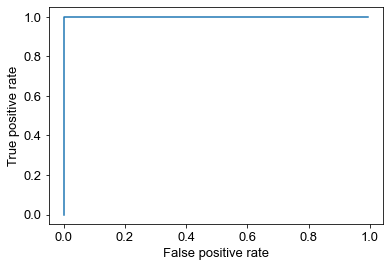

[[0.0342874, 1.0, 0.995],
 [0.034475245445445446, 1.0, 0.995],
 [0.034663090890890896, 1.0, 0.995],
 [0.03485093633633634, 1.0, 0.99],
 [0.03503878178178178, 1.0, 0.99],
 [0.03522662722722723, 1.0, 0.99],
 [0.03541447267267268, 1.0, 0.985],
 [0.03560231811811812, 1.0, 0.98],
 [0.035790163563563564, 1.0, 0.98],
 [0.035978009009009014, 1.0, 0.98],
 [0.03616585445445446, 1.0, 0.98],
 [0.0363536998998999, 1.0, 0.98],
 [0.03654154534534535, 1.0, 0.98],
 [0.036729390790790795, 1.0, 0.98],
 [0.03691723623623624, 1.0, 0.98],
 [0.03710508168168168, 1.0, 0.98],
 [0.03729292712712713, 1.0, 0.975],
 [0.037480772572572575, 1.0, 0.975],
 [0.03766861801801802, 1.0, 0.975],
 [0.03785646346346347, 1.0, 0.975],
 [0.03804430890890891, 1.0, 0.975],
 [0.038232154354354356, 1.0, 0.975],
 [0.038419999799799806, 1.0, 0.975],
 [0.03860784524524525, 1.0, 0.97],
 [0.03879569069069069, 1.0, 0.97],
 [0.038983536136136136, 1.0, 0.97],
 [0.03917138158158159, 1.0, 0.97],
 [0.03935922702702703, 1.0, 0.97],
 [0.0395470

In [190]:
plot_roc_curve(s1_noise_list_tb_005, s1_signal_list_05_tb_005_check_f, 1000, 1, plot_title = None, fig_name = "tb005_checkf")

To obtain ROC curves for different amplitudes and also for method 2, the following results are calculated and saved in lists of S1-values:

In [102]:
s1_noise_list_tb_005 = []
s2_noise_list_tb_005 = []
s1_noise_list_1_tb_005 = []
s2_noise_list_1_tb_005 = []
s1_signal_list_05_tb_005 = []
s2_signal_list_05_tb_005 = []
s1_signal_list_1_tb_005 = []
s2_signal_list_1_tb_005 = []
s1_signal_list_15_tb_005 = []
s2_signal_list_15_tb_005 = []
s1_signal_list_2_tb_005 = []
s2_signal_list_2_tb_005 = []
for i in range(200):
    s1_noise_list_tb_005.append(get_best_result(noise_list_results_m1_tb_005[i], method = 1)[2])
    s2_noise_list_tb_005.append(get_best_result(noise_list_results_m2_tb_005[i], method = 2)[2])
    s1_noise_list_1_tb_005.append(get_best_result(noise_list_1_results_m1_tb_005[i], method = 1)[2])
    s2_noise_list_1_tb_005.append(get_best_result(noise_list_1_results_m2_tb_005[i], method = 2)[2])
    s1_signal_list_05_tb_005.append(get_best_result(signal_list_05_results_m1_tb_005[i], method = 1)[2])
    s2_signal_list_05_tb_005.append(get_best_result(signal_list_05_results_m2_tb_005[i], method = 2)[2])
    s1_signal_list_1_tb_005.append(get_best_result(signal_list_1_results_m1_tb_005[i], method = 1)[2])
    s2_signal_list_1_tb_005.append(get_best_result(signal_list_1_results_m2_tb_005[i], method = 2)[2])
    s1_signal_list_15_tb_005.append(get_best_result(signal_list_15_results_m1_tb_005[i], method = 1)[2])
    s2_signal_list_15_tb_005.append(get_best_result(signal_list_15_results_m2_tb_005[i], method = 2)[2])
    s1_signal_list_2_tb_005.append(get_best_result(signal_list_2_results_m1_tb_005[i], method = 1)[2])
    s2_signal_list_2_tb_005.append(get_best_result(signal_list_2_results_m2_tb_005[i], method = 2)[2])

In [125]:
s1_noise_list_tb_005_check_f = []
s2_noise_list_tb_005_check_f = []
s1_signal_list_05_tb_005_check_f = []
s2_signal_list_05_tb_005_check_f = []
for i in range(200):
    s1_noise_list_tb_005_check_f.append(get_best_result(noise_list_results_m1_tb_005[i], method = 1))
    s2_noise_list_tb_005_check_f.append(get_best_result(noise_list_results_m2_tb_005[i], method = 2))
    s1_signal_list_05_tb_005_check_f.append(get_best_result(signal_list_05_results_m1_tb_005[i], method = 1))
    s2_signal_list_05_tb_005_check_f.append(get_best_result(signal_list_05_results_m2_tb_005[i], method = 2))

The distributions of the best results for S1 and S2 for pure noise and noise + signal are plotted in a histogram for both methods:

In [82]:
# plots a histogram of the s-values in s_noise_list and s_signal_list
# saves plot in a png image with the given file name
def plot_histogram(s_noise_list, s_signal_list, method = 1, plot_title = None, fig_name = None):
    
    plt.hist(s_noise_list, bins = 200, label = "Noise")
    plt.hist(s_signal_list, bins = 200, label = "Noise and signal")
    plt.xlabel(f"S$_{str(method)}$", fontname="Arial", fontsize=13)
    plt.ylabel("Number", fontname="Arial", fontsize=13)
    plt.xticks(fontname="Arial", fontsize=13)
    plt.yticks(fontname="Arial", fontsize=13)
    if plot_title:
        plt.title(f"Histogram for method {str(method)}, {plot_title}")
    else:
        plt.title(f"Histogram for method {str(method)}")
    plt.legend(loc='upper left')
    plt.savefig(f"histogram_mod{str(method)}_{fig_name}.png", dpi=800)
    plt.show()
    
    return 

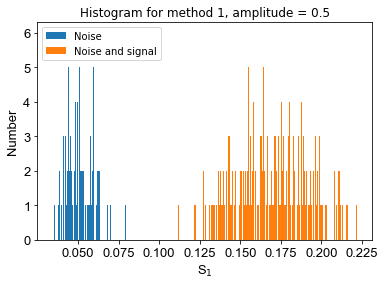

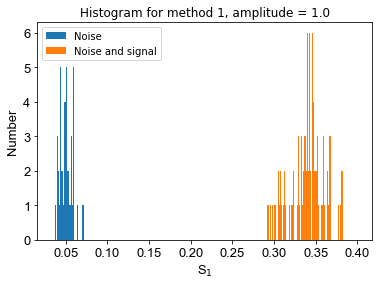

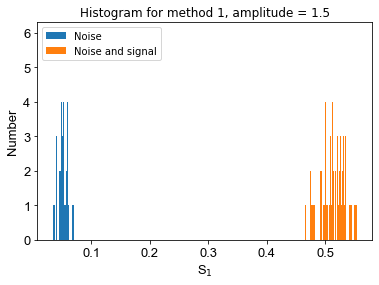

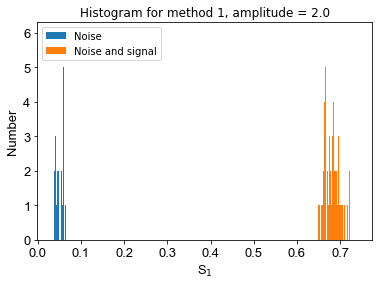

In [103]:
plot_histogram(s1_noise_list_1_tb_005, s1_signal_list_05_tb_005, method = 1, plot_title = "amplitude = 0.5", fig_name = "a_05")
plot_histogram(s1_noise_list_1_tb_005, s1_signal_list_1_tb_005, method = 1, plot_title = "amplitude = 1.0", fig_name = "a_1")
plot_histogram(s1_noise_list_1_tb_005, s1_signal_list_15_tb_005, method = 1, plot_title = "amplitude = 1.5", fig_name = "a_15")
plot_histogram(s1_noise_list_1_tb_005, s1_signal_list_2_tb_005, method = 1, plot_title = "amplitude = 2.0", fig_name = "a_2")

Using the results of prober, the ROC curve is obtained by plotting the true positive rate vs. the false positive rate for varying thresholds of S1 or S2, respectively. 

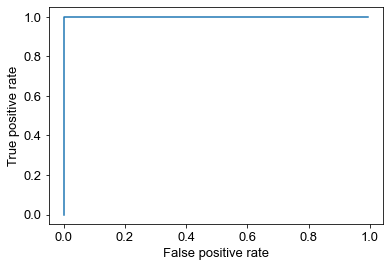

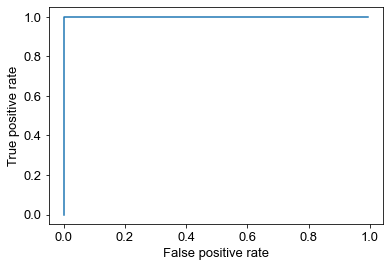

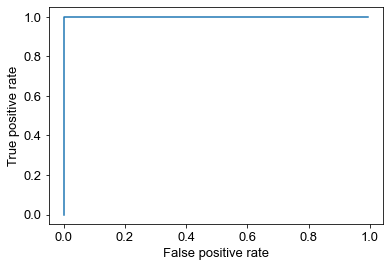

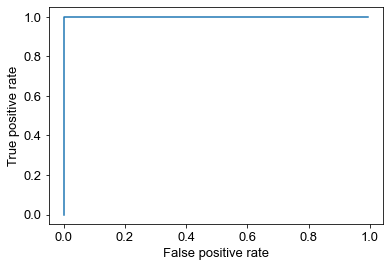

[[0.0342874, 1.0, 0.995],
 [0.03569959158316634, 1.0, 0.98],
 [0.037111783166332665, 1.0, 0.98],
 [0.038523974749499, 1.0, 0.975],
 [0.039936166332665335, 1.0, 0.965],
 [0.04134835791583167, 1.0, 0.935],
 [0.042760549498998, 1.0, 0.855],
 [0.04417274108216433, 1.0, 0.835],
 [0.04558493266533067, 1.0, 0.795],
 [0.046997124248497, 1.0, 0.745],
 [0.04840931583166333, 1.0, 0.68],
 [0.049821507414829665, 1.0, 0.625],
 [0.051233698997996, 1.0, 0.535],
 [0.05264589058116233, 1.0, 0.475],
 [0.05405808216432866, 1.0, 0.39],
 [0.055470273747495, 1.0, 0.33],
 [0.056882465330661325, 1.0, 0.31],
 [0.05829465691382766, 1.0, 0.245],
 [0.059706848496993994, 1.0, 0.2],
 [0.06111904008016032, 1.0, 0.18],
 [0.06253123166332666, 1.0, 0.16],
 [0.06394342324649299, 1.0, 0.14],
 [0.06535561482965932, 1.0, 0.13],
 [0.06676780641282566, 1.0, 0.11],
 [0.06817999799599199, 1.0, 0.08],
 [0.06959218957915833, 1.0, 0.075],
 [0.07100438116232466, 1.0, 0.065],
 [0.07241657274549099, 1.0, 0.055],
 [0.07382876432865731

In [124]:
plot_roc_curve(s1_noise_list_tb_005, s1_signal_list_05_tb_005, 500, 1, fig_name = "noise05")
plot_roc_curve(s1_noise_list_tb_005, s1_signal_list_1_tb_005, 500, 1, fig_name = "noise1")
plot_roc_curve(s1_noise_list_tb_005, s1_signal_list_15_tb_005, 500, 1, fig_name = "noise15")
plot_roc_curve(s1_noise_list_tb_005, s1_signal_list_2_tb_005, 500, 1, fig_name = "noise2")

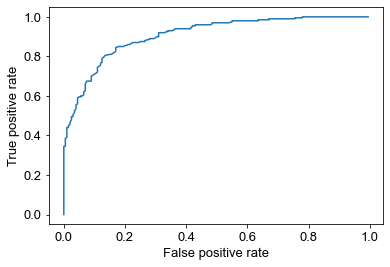

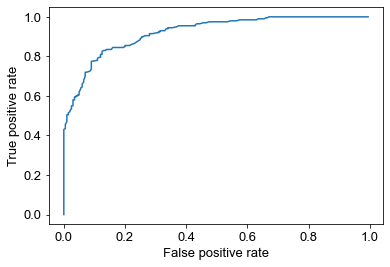

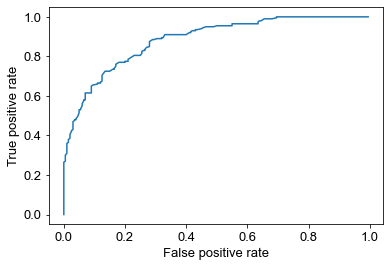

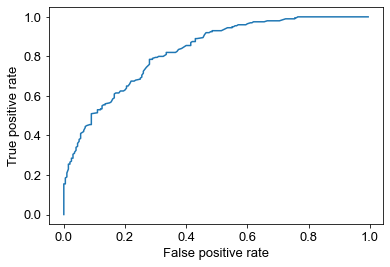

[[623.359, 0.0, 0.0],
 [623.3727214428858, 0.005, 0.0],
 [623.3864428857715, 0.005, 0.0],
 [623.4001643286573, 0.005, 0.0],
 [623.4138857715432, 0.005, 0.0],
 [623.4276072144289, 0.005, 0.0],
 [623.4413286573147, 0.005, 0.0],
 [623.4550501002004, 0.005, 0.0],
 [623.4687715430862, 0.005, 0.0],
 [623.4824929859719, 0.005, 0.0],
 [623.4962144288578, 0.005, 0.0],
 [623.5099358717436, 0.01, 0.0],
 [623.5236573146293, 0.01, 0.0],
 [623.5373787575151, 0.01, 0.0],
 [623.5511002004008, 0.01, 0.0],
 [623.5648216432866, 0.01, 0.0],
 [623.5785430861724, 0.01, 0.0],
 [623.5922645290582, 0.01, 0.0],
 [623.6059859719439, 0.01, 0.0],
 [623.6197074148297, 0.01, 0.0],
 [623.6334288577154, 0.01, 0.0],
 [623.6471503006012, 0.01, 0.0],
 [623.6608717434871, 0.01, 0.0],
 [623.6745931863728, 0.01, 0.0],
 [623.6883146292586, 0.01, 0.0],
 [623.7020360721443, 0.01, 0.0],
 [623.7157575150301, 0.01, 0.0],
 [623.7294789579158, 0.01, 0.0],
 [623.7432004008016, 0.01, 0.0],
 [623.7569218436875, 0.01, 0.0],
 [623.77064

In [106]:
plot_roc_curve(s2_noise_list_1_tb_005, s2_signal_list_05_tb_005, 500, 2, fig_name = "noise05")
plot_roc_curve(s2_noise_list_1_tb_005, s2_signal_list_1_tb_005, 500, 2, fig_name = "noise1")
plot_roc_curve(s2_noise_list_1_tb_005, s2_signal_list_15_tb_005, 500, 2, fig_name = "noise15")
plot_roc_curve(s2_noise_list_1_tb_005, s2_signal_list_2_tb_005, 500, 2, fig_name = "noise2")

## ROC-Curves for Stage 2

Analogously to above, the ROC curves are also plotted for the template banks used in stage 2 of the search.

In [107]:
temp_bank_for_roc_stage2 = generate_template_bank(437.117, 437.137, 20, 2.3, 2.5, 5, "temp_bank_for_roc_stage2.txt")

In [108]:
noise_list_results_m1_stage2 = []
noise_list_1_results_m1_stage2 = []
signal_list_05_results_m1_stage2 = []
signal_list_2_results_m1_stage2 = []
noise_list_results_m2_stage2 = []
noise_list_1_results_m2_stage2 = []
signal_list_05_results_m2_stage2 = []
signal_list_2_results_m2_stage2 = []
for i in range(200):
    noise_list_results_m1_stage2.append(prober(noise_list[i], outputFile=f"noise_list_result_f{str(i)}_stage2_m1.txt", 
                                            templateFile=temp_bank_for_roc_stage2, mod=1))
    noise_list_results_m2_stage2.append(prober(noise_list[i], outputFile=f"noise_list_result_f{str(i)}_stage2_m2.txt", 
                                            templateFile=temp_bank_for_roc_stage2, mod=2))
    noise_list_1_results_m1_stage2.append(prober(noise_list_1[i], outputFile=f"noise_list_1_result_f{str(i)}_stage2_m1.txt", 
                                            templateFile=temp_bank_for_roc_stage2, mod=1))
    noise_list_1_results_m2_stage2.append(prober(noise_list_1[i], outputFile=f"noise_list_1_result_f{str(i)}_stage2_m2.txt", 
                                            templateFile=temp_bank_for_roc_stage2, mod=2))
    signal_list_05_results_m1_stage2.append(prober(signal_list_05[i], outputFile=f"signal_list_05_result_f{str(i)}_stage2_m1.txt", 
                                            templateFile=temp_bank_for_roc_stage2, mod=1))
    signal_list_05_results_m2_stage2.append(prober(signal_list_05[i], outputFile=f"signal_list_05_result_f{str(i)}_stage2_m2.txt", 
                                            templateFile=temp_bank_for_roc_stage2, mod=2))
    signal_list_2_results_m1_stage2.append(prober(signal_list_2[i], outputFile=f"signal_list_2_result_f{str(i)}_stage2_m1.txt", 
                                            templateFile=temp_bank_for_roc_stage2, mod=1))
    signal_list_2_results_m2_stage2.append(prober(signal_list_2[i], outputFile=f"signal_list_2_result_f{str(i)}_stage2_m2.txt", 
                                            templateFile=temp_bank_for_roc_stage2, mod=2))

In [109]:
s1_noise_list_stage2 = []
s2_noise_list_stage2 = []
s1_noise_list_1_stage2 = []
s2_noise_list_1_stage2 = []
s1_signal_list_05_stage2 = []
s2_signal_list_05_stage2 = []
s1_signal_list_2_stage2 = []
s2_signal_list_2_stage2 = []
for i in range(200):
    s1_noise_list_stage2.append(get_best_result(noise_list_results_m1_stage2[i], method = 1)[2])
    s2_noise_list_stage2.append(get_best_result(noise_list_results_m2_stage2[i], method = 2)[2])
    s1_noise_list_1_stage2.append(get_best_result(noise_list_1_results_m1_stage2[i], method = 1)[2])
    s2_noise_list_1_stage2.append(get_best_result(noise_list_1_results_m2_stage2[i], method = 2)[2])
    s1_signal_list_05_stage2.append(get_best_result(signal_list_05_results_m1_stage2[i], method = 1)[2])
    s2_signal_list_05_stage2.append(get_best_result(signal_list_05_results_m2_stage2[i], method = 2)[2])
    s1_signal_list_2_stage2.append(get_best_result(signal_list_2_results_m1_stage2[i], method = 1)[2])
    s2_signal_list_2_stage2.append(get_best_result(signal_list_2_results_m2_stage2[i], method = 2)[2])

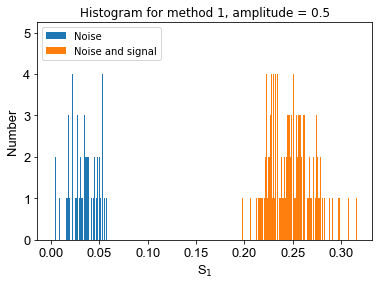

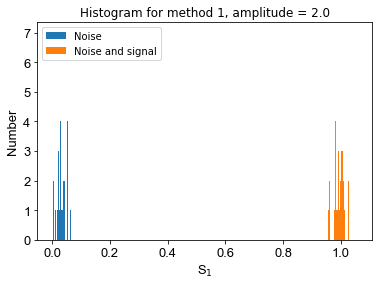

In [110]:
plot_histogram(s1_noise_list_1_stage2, s1_signal_list_05_stage2, method = 1, plot_title = "amplitude = 0.5", fig_name = "a_05_stage2")
plot_histogram(s1_noise_list_1_stage2, s1_signal_list_2_stage2, method = 1, plot_title = "amplitude = 2.0", fig_name = "a_2_stage2")

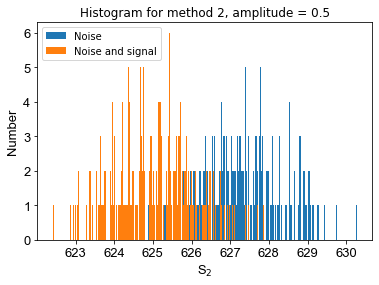

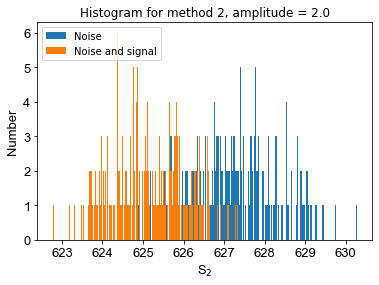

In [111]:
plot_histogram(s2_noise_list_1_stage2, s2_signal_list_05_stage2, method = 2, plot_title = "amplitude = 0.5", fig_name = "a_05_stage2")
plot_histogram(s2_noise_list_1_stage2, s2_signal_list_2_stage2, method = 2, plot_title = "amplitude = 2.0", fig_name = "a_2_stage2")

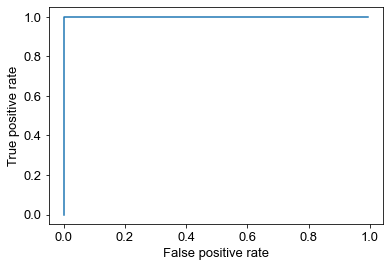

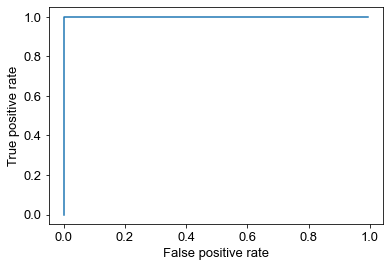

[[0.00170277, 1.0, 0.995],
 [0.0038156702605210424, 1.0, 0.995],
 [0.005928570521042085, 1.0, 0.98],
 [0.008041470781563127, 1.0, 0.975],
 [0.010154371042084168, 1.0, 0.97],
 [0.012267271302605211, 1.0, 0.96],
 [0.014380171563126253, 1.0, 0.95],
 [0.016493071823647294, 1.0, 0.92],
 [0.018605972084168337, 1.0, 0.885],
 [0.02071887234468938, 1.0, 0.865],
 [0.022831772605210424, 1.0, 0.81],
 [0.024944672865731463, 1.0, 0.75],
 [0.027057573126252506, 1.0, 0.7],
 [0.02917047338677355, 1.0, 0.645],
 [0.03128337364729459, 1.0, 0.59],
 [0.03339627390781563, 1.0, 0.55],
 [0.035509174168336675, 1.0, 0.47],
 [0.03762207442885772, 1.0, 0.375],
 [0.03973497468937876, 1.0, 0.335],
 [0.041847874949899805, 1.0, 0.325],
 [0.04396077521042085, 1.0, 0.27],
 [0.046073675470941884, 1.0, 0.21],
 [0.04818657573146293, 1.0, 0.165],
 [0.05029947599198397, 1.0, 0.13],
 [0.052412376252505014, 1.0, 0.11],
 [0.05452527651302606, 1.0, 0.06],
 [0.0566381767735471, 1.0, 0.045],
 [0.05875107703406814, 1.0, 0.03],
 [0.

In [112]:
plot_roc_curve(s1_noise_list_1_stage2, s1_signal_list_05_stage2, 500, 1, fig_name = "a_05_stage2")
plot_roc_curve(s1_noise_list_1_stage2, s1_signal_list_2_stage2, 500, 1, fig_name = "a_2_stage2")

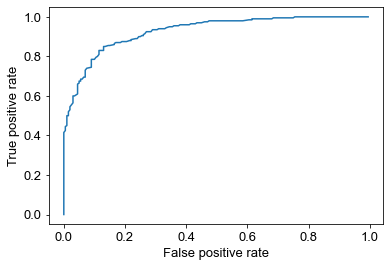

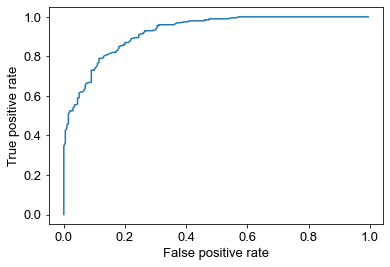

[[622.772, 0.0, 0.0],
 [622.7870480961924, 0.005, 0.0],
 [622.8020961923849, 0.005, 0.0],
 [622.8171442885772, 0.005, 0.0],
 [622.8321923847695, 0.005, 0.0],
 [622.847240480962, 0.01, 0.0],
 [622.8622885771543, 0.01, 0.0],
 [622.8773366733467, 0.01, 0.0],
 [622.8923847695391, 0.01, 0.0],
 [622.9074328657315, 0.01, 0.0],
 [622.9224809619238, 0.01, 0.0],
 [622.9375290581163, 0.01, 0.0],
 [622.9525771543086, 0.01, 0.0],
 [622.9676252505011, 0.01, 0.0],
 [622.9826733466934, 0.01, 0.0],
 [622.9977214428858, 0.01, 0.0],
 [623.0127695390782, 0.01, 0.0],
 [623.0278176352706, 0.01, 0.0],
 [623.0428657314629, 0.01, 0.0],
 [623.0579138276554, 0.01, 0.0],
 [623.0729619238477, 0.01, 0.0],
 [623.0880100200401, 0.01, 0.0],
 [623.1030581162325, 0.01, 0.0],
 [623.1181062124249, 0.01, 0.0],
 [623.1331543086172, 0.01, 0.0],
 [623.1482024048097, 0.01, 0.0],
 [623.163250501002, 0.01, 0.0],
 [623.1782985971944, 0.01, 0.0],
 [623.1933466933868, 0.01, 0.0],
 [623.2083947895792, 0.015, 0.0],
 [623.223442885771

In [113]:
plot_roc_curve(s2_noise_list_1_stage2, s2_signal_list_05_stage2, 500, 2, fig_name = "a_05_stage2")
plot_roc_curve(s2_noise_list_1_stage2, s2_signal_list_2_stage2, 500, 2, fig_name = "a_2_stage2")